# --- START ---

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 30)
# pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from tqdm.notebook import tqdm
import cv2
import os
import glob
import gc
from IPython.display import display
sns.set()

# 銀行のマーケティングキャンペーンに参加するかどうか（Bank Marketing Data Set）
・http://archive.ics.uci.edu/ml/datasets/Bank+Marketing  
・bank.zip と bank-additional.zip がある（bank.zipの方が特徴量が単純なのでこちらを使用）  
・bank.zipの中に bank.csv と bank-full.csv があり、レコード数が違うよう  
・目的変数のアンバランス  
・欠損なし（unknownはあり）  
・年月日の扱いが面倒  
・日本語参考：https://qiita.com/kenichiro-yamato/items/cc6b41a277458efb139d  

# ダウンロード & 解凍

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2023-04-02 11:16:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 565.47K  2.24MB/s    in 0.2s    

2023-04-02 11:16:50 (2.24 MB/s) - ‘bank.zip’ saved [579043/579043]



In [3]:
!unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [4]:
!ls -ltr bank*

-rw-r--r-- 1 root root  461474 Feb 14  2012 bank.csv
-rw-r--r-- 1 root root 4610348 Feb 14  2012 bank-full.csv
-rw-r--r-- 1 root root    3864 Feb 14  2012 bank-names.txt
-rw-r--r-- 1 root root  579043 Feb 14  2012 bank.zip


In [5]:
# df = pd.read_csv('bank.csv', sep=';')
df = pd.read_csv('bank-full.csv', sep=';')
print(df.shape)
display(df.head())

# age: 顧客の年齢（数値）
# job: 顧客の職業（カテゴリ変数）
# marital: 顧客の婚姻状況（カテゴリ変数）
# education: 顧客の教育水準（カテゴリ変数）
# default: 顧客がデフォルトしたかどうか（カテゴリ変数）yes / no
# balance: 顧客の口座残高（数値）
# housing: 顧客が住宅ローンを持っているかどうか（カテゴリ変数）yes / no
# loan: 顧客が個人ローンを持っているかどうか（カテゴリ変数）yes / no
# contact: 連絡方法（カテゴリ変数）
# day: 最後に顧客に連絡した日にち（数値）
# month: 最後に顧客に連絡した月（カテゴリ変数）
# duration: 最後の連絡の通話時間（秒数）
# campaign: 今回のキャンペーンで顧客に連絡した回数（数値）
# pdays: 以前のマーケティングキャンペーンにおける顧客への最終連絡日からの経過日数。-1は以前の連絡が無かったことを示す。（数値）
# previous: 以前のマーケティングキャンペーンにおける顧客への連絡回数（数値）
# poutcome: 最後のマーケティングキャンペーンの結果（カテゴリ変数）
# y: 顧客が定期預金を申し込んだかどうか（目的変数、カテゴリ変数）yes / no

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# org

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


#//$// 少ない方のデータ数に合わせてダウンサンプリングを行う
print('before', df.shape)

counts = df['y'].value_counts()
df_majority = df[df['y']=='no']
df_minority = df[df['y']=='yes']
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # オーバーサンプリングではないのでFalse
                                   n_samples=counts[1], # 少ない方のデータ数に合わせる
                                   random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# display(df_downsampled)

df = df_downsampled.copy()
df.reset_index(inplace=True, drop=True)

print('after', df.shape)
#//$//


#//$//
df.drop('poutcome',axis=1,inplace=True) # 重要な特徴量だが、欠損値が多いため、特徴量自体を除去
#//$//


# 特徴量と目的変数を準備する
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# カテゴリ変数を数値に変換する
le = LabelEncoder()
X = X.apply(le.fit_transform)


#//$//
dict_mapping = {'no':0, 'yes':1}
y = y.map(dict_mapping)
#//$//


# 訓練用とテスト用にデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# display(X_train)
# display(X_test)
# display(y_train)
# display(y_test)

# モデルを作成して学習する
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# テスト用データで予測して評価する
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

before (45211, 17)
after (10578, 17)
Accuracy: 0.8431001890359168
F1 score: 0.8527062999112688


# =============================================== #

# 配布前処理

In [7]:
# df = df.replace('unknown', np.nan, regex=True)
# df.head()

# ロード

In [8]:
df = pd.read_csv('bank-full.csv', sep=';')

# 特徴量選択
df = df.drop(['day', 'month'], axis=1)

print(df.shape)
display(df.head())

(45211, 15)


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


# 基本統計量確認

In [10]:
# 数値変数
df.describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [11]:
# カテゴリ変数
df.describe(exclude='number')

,job,marital,education,default,housing,loan,contact,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,36959,39922


# 一括分布確認

lst_col_number 6 ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
lst_col_category 9 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
age


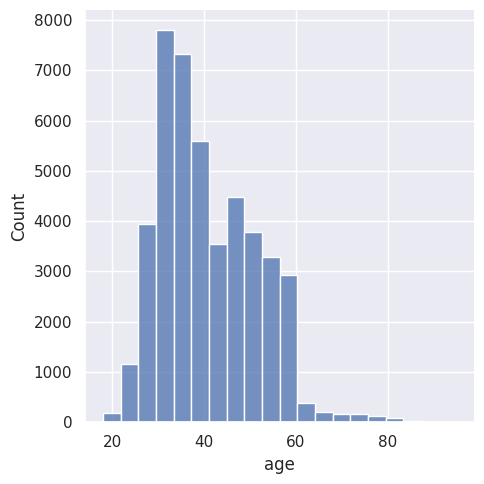

job


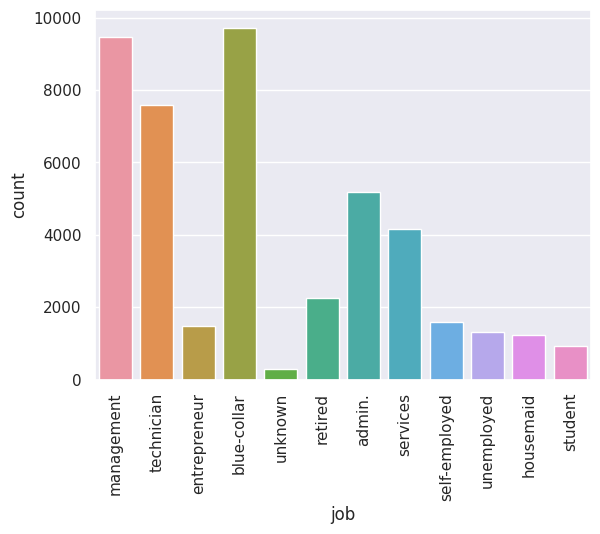

marital


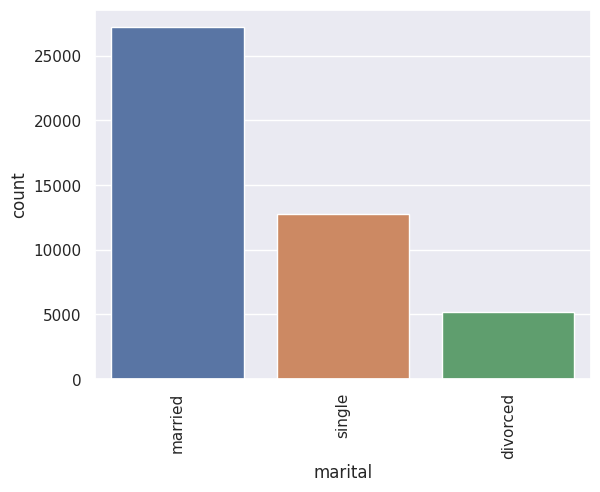

education


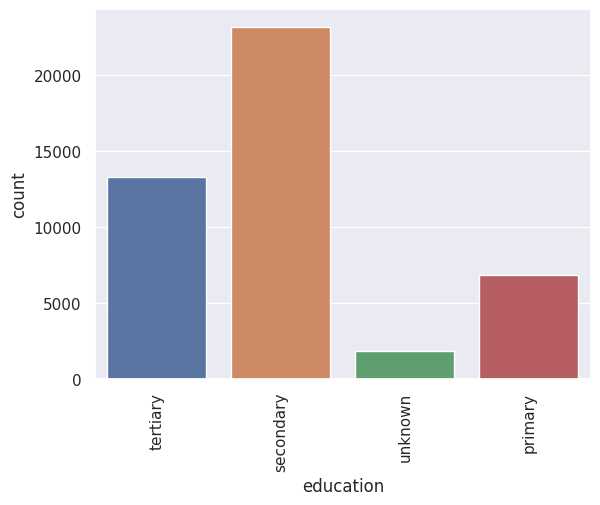

default


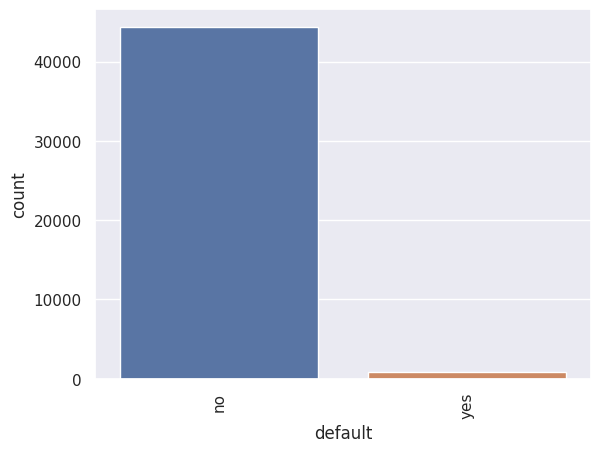

balance


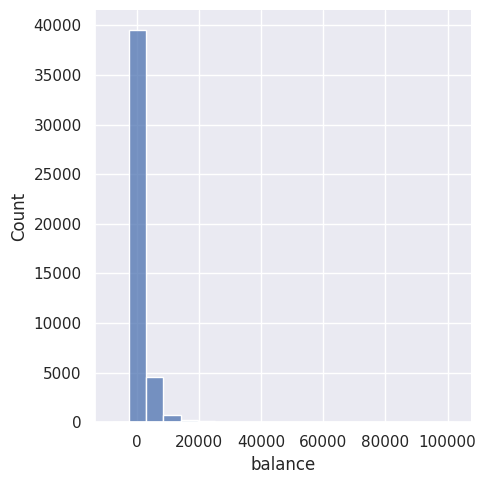

housing


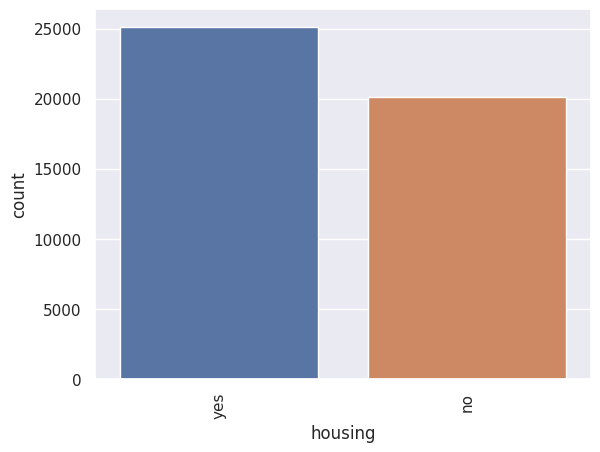

loan


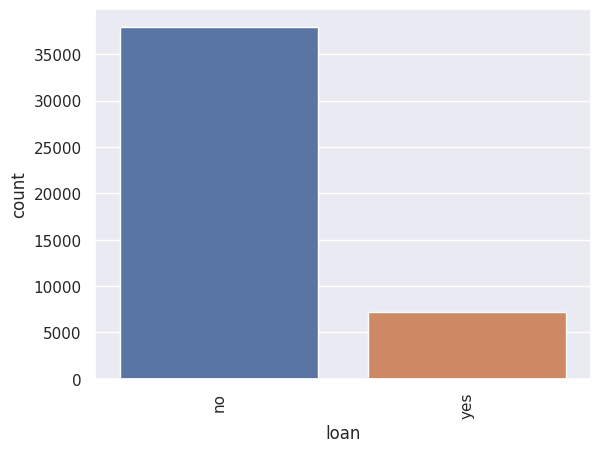

contact


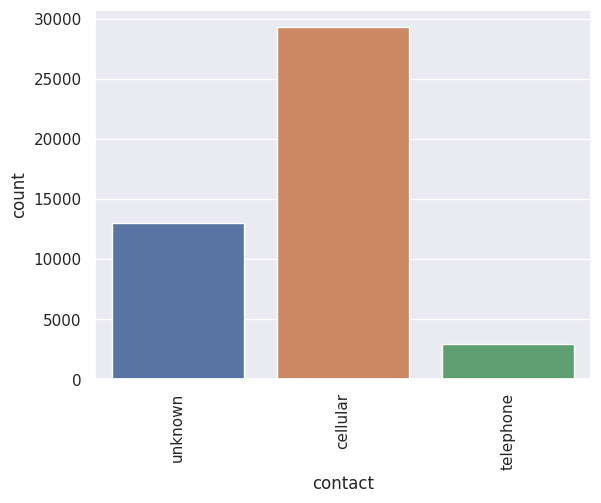

duration


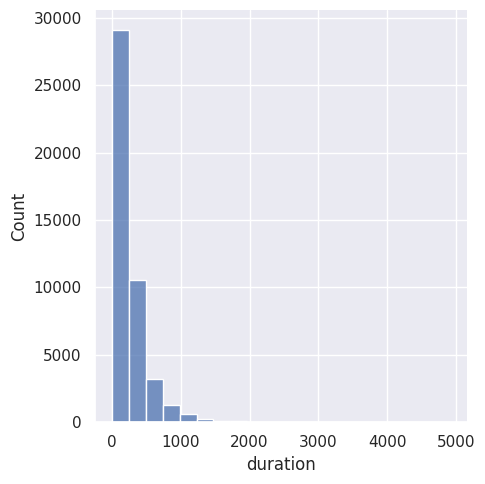

campaign


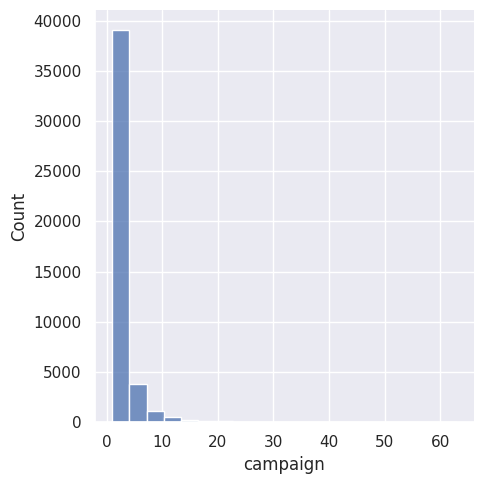

pdays


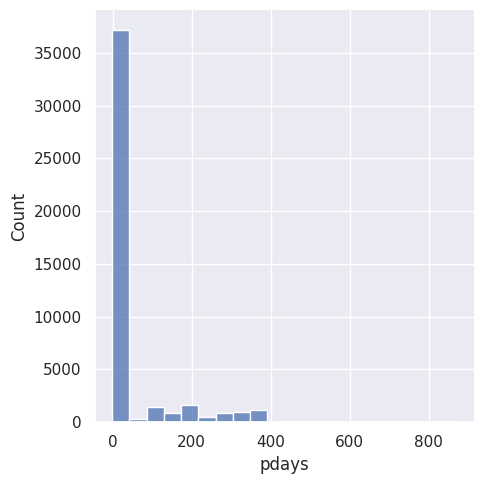

previous


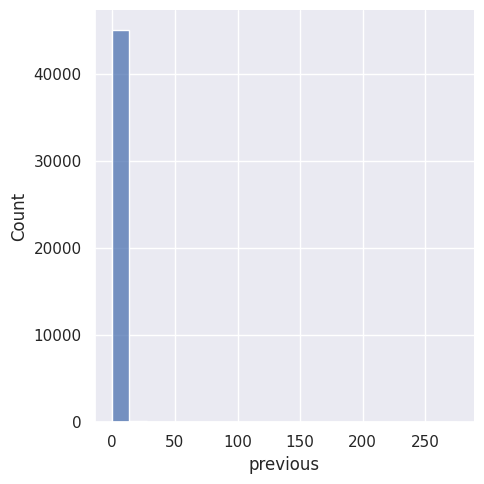

poutcome


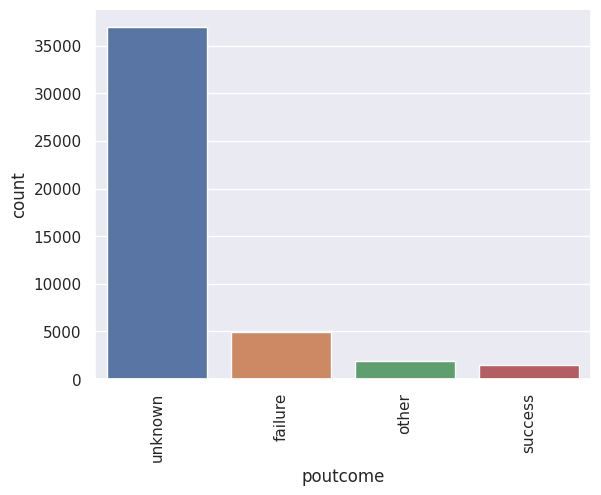

y


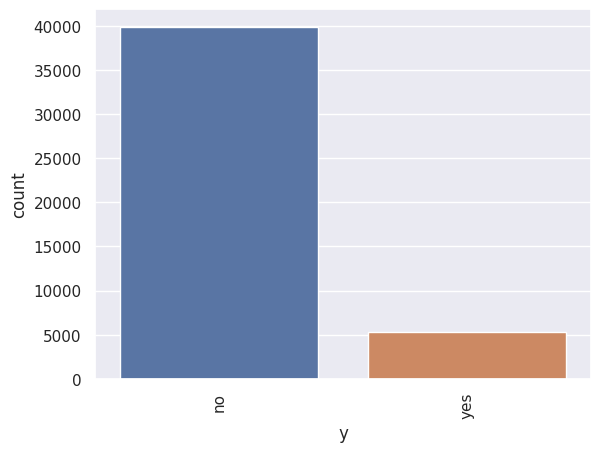

In [12]:
lst_col_number = list(df.select_dtypes(include=np.number).columns)
lst_col_category = list(df.select_dtypes(exclude=np.number).columns)
print('lst_col_number', len(lst_col_number), lst_col_number)
print('lst_col_category', len(lst_col_category), lst_col_category)


# def sturges(n):
#     bins = int(math.ceil(math.log2(n))) + 1
#     return bins


for col in df.columns:
    print(col)

    #################################################
    # category columns
    #################################################
    if col in lst_col_category:
        # fig, ax = plt.subplots(figsize=(25, 5))
        sns.countplot(x=col, data=df)
        plt.xticks(rotation=90)
        plt.show()

    #################################################
    # number columns
    #################################################
    elif col in lst_col_number:
        # fig, ax = plt.subplots(figsize=(25, 5))
        sns.displot(x=col, data=df, bins=20)
        # sns.displot(x=col, data=df, bins=sturges(len(df)))
        plt.show()

    else:
        print("*** unexpected type ***")
        # sys.exit()

# 可視化

In [13]:
# def sturges(n):
#     bins = int(math.ceil(math.log2(n))) + 1
#     return bins

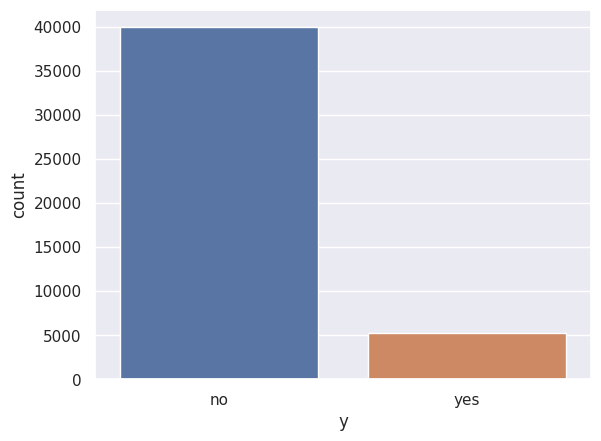

In [14]:
sns.countplot(x='y', data=df)
plt.show()

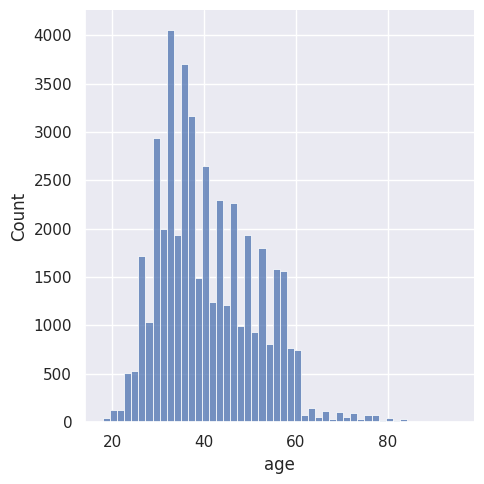

In [15]:
# sns.displot(x='age', data=df)
sns.displot(x='age', data=df, bins=50)
# sns.displot(x='age', data=df, bins=sturges(len(df)))
plt.show()

In [16]:
# sns.pairplot(df, hue='y')
# plt.show()

# 欠損値処理（今回はカテゴリ特徴量のみに欠損）
・欠損値は"unknown"の文字列で示されている

In [17]:
# 欠損したレコードを捨てる  'job'
# 特徴量自体を捨ててしまう
# 補間する
# 予測する
# 敢えて欠損値として取り扱う（欠損していることに意味がある場合）

# → バックグランドを理解した上で、適切な処理をすることが重要

In [18]:
# "unknown"の文字列が含まれる特徴量を抽出

# unknown_cols = []
# for col in df.columns:
#     if df[col].isin(['unknown']).any():
#         unknown_cols.append(col)
#     elif df[col].apply(lambda x: 'unknown' in str(x)).any():
#         unknown_cols.append(col)
        
# print(unknown_cols)


unknown_cols = []
for col in df.columns:
    unknown_count = df[col].isin(['unknown']).sum()
    if unknown_count > 0:
        unknown_ratio = round(unknown_count / df.shape[0], 4)
        unknown_cols.append((col, unknown_ratio))
    else:
        unknown_count = df[col].apply(lambda x: 'unknown' in str(x)).sum()
        unknown_ratio = round(unknown_count / df.shape[0], 4)
        if unknown_count > 0:
            unknown_cols.append((col, unknown_ratio))
        
print(unknown_cols)

[('job', 0.0064), ('education', 0.0411), ('contact', 0.288), ('poutcome', 0.8175)]


## 'job' → 欠損したレコードを捨てる

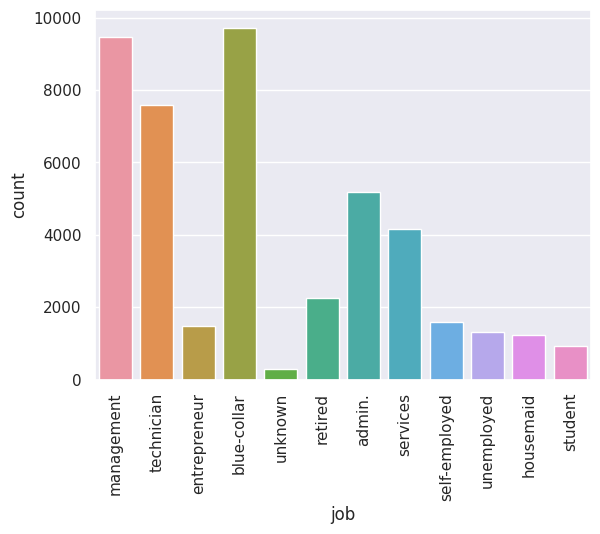

In [19]:
sns.countplot(x='job', data=df)
plt.xticks(rotation=90)
plt.show()

In [20]:
df.shape

(45211, 15)

In [21]:
df = df.drop(df[df['job']=='unknown'].index)

# インデックスを振り直す
df.reset_index(inplace=True, drop=True)

In [22]:
df.shape

(44923, 15)

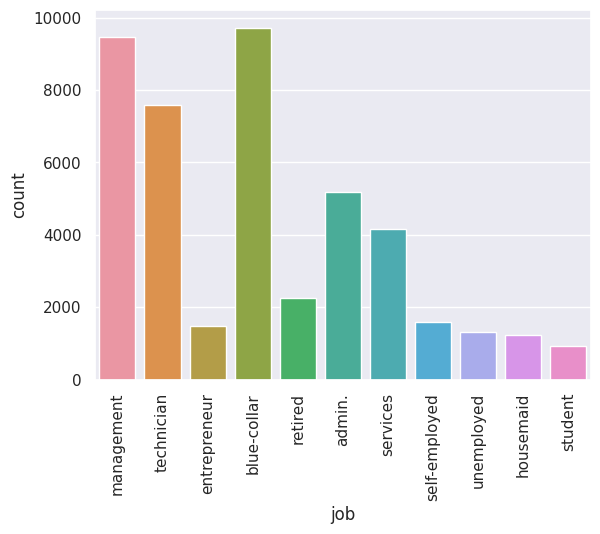

In [23]:
sns.countplot(x='job', data=df)
plt.xticks(rotation=90)
plt.show()

## 'education' → 代表値で補間

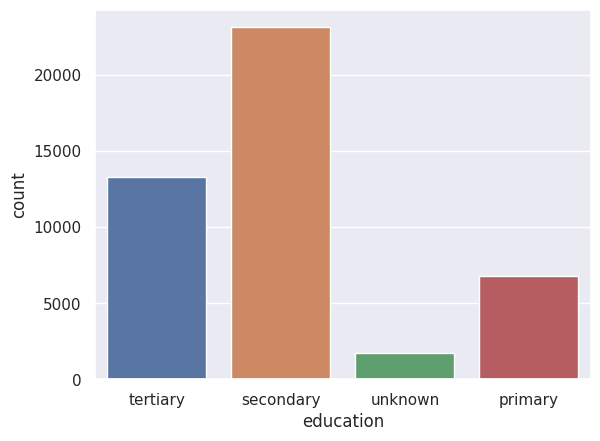

In [24]:
sns.countplot(x='education', data=df)
plt.show()

In [25]:
df['education'] = df['education'].replace('unknown','secondary', regex=True)

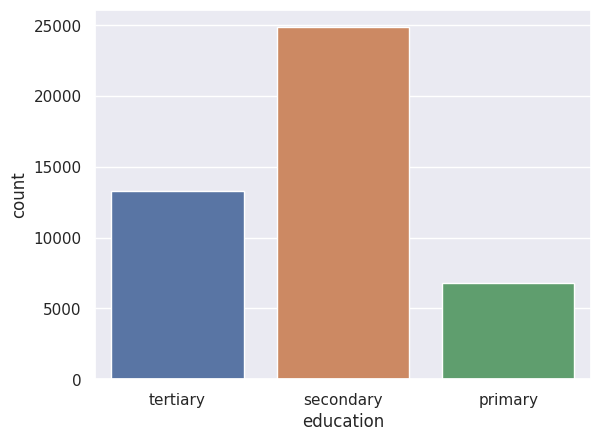

In [26]:
sns.countplot(x='education', data=df)
plt.show()

## 'contact' → 敢えて欠損として取り扱う

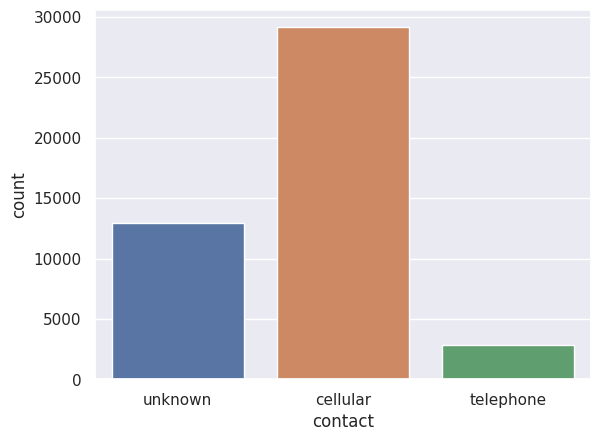

In [27]:
sns.countplot(x='contact', data=df)
plt.show()

## 'poutcome' → 特徴量自体を捨てる

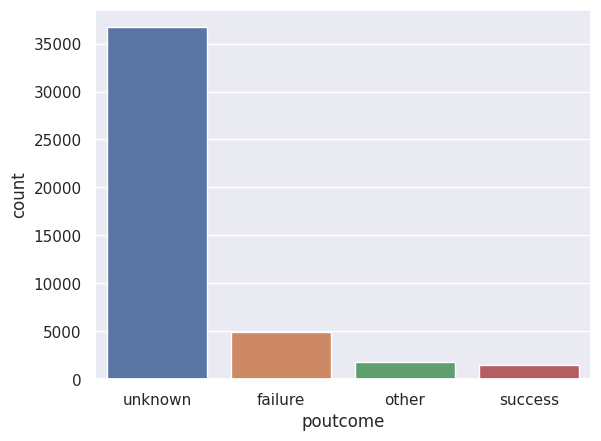

In [28]:
sns.countplot(x='poutcome', data=df)
plt.show()

In [29]:
df.shape

(44923, 15)

In [30]:
df.drop('poutcome',axis=1,inplace=True)

In [31]:
df.shape

(44923, 14)

# 外れ値の処理（数値特徴量）

In [32]:
# 数値変数
df.describe()

,age,balance,duration,campaign,pdays,previous
count,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000,44923.000000
mean,40.893529,1359.643011,258.294838,2.760345,40.321016,0.581996
std,10.604399,3045.091520,257.713770,3.092838,100.255146,2.309077
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,447.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1421.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## 'balance' → 正規分布ではないが近いので3σ法でclip（マイナスの値はとっておく）

In [33]:
df['balance'].describe()

count     44923.000000
mean       1359.643011
std        3045.091520
min       -8019.000000
25%          72.000000
50%         447.000000
75%        1421.000000
max      102127.000000
Name: balance, dtype: float64

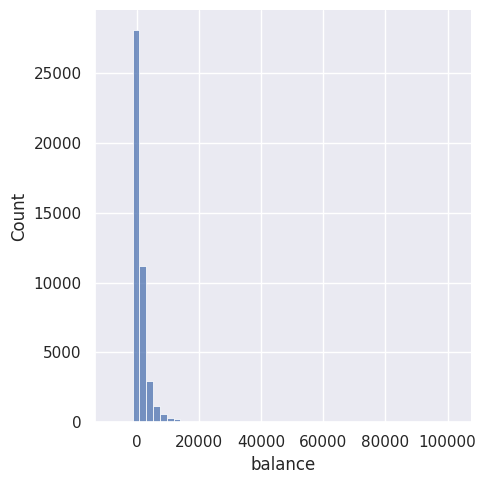

In [34]:
# sns.displot(x='balance', data=df)
sns.displot(x='balance', data=df, bins=50)
# sns.displot(x='balance', data=df, bins=sturges(len(df)))
plt.show()

In [35]:
# sns.scatterplot(data=df, x='balance', y='y')
# # sns.scatterplot(data=df, x='balance', y='age')

In [36]:
# sns.jointplot(x=df['balance'], y=df['age'])

In [37]:
mean = df['balance'].mean()
std = df['balance'].std()

print('mean', mean)
print('std', std)

mean 1359.6430113750196
std 3045.091519830184


In [38]:
upper = mean + 3*std
lower = mean - 3*std

print('upper', upper)
print('lower', lower)

upper 10494.917570865571
lower -7775.6315481155325


In [39]:
df.loc[df['balance']>upper, 'balance'] = upper
df.loc[df['balance']<lower, 'balance'] = lower

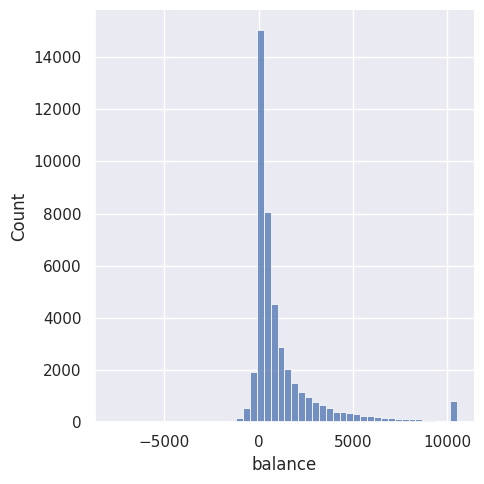

In [40]:
sns.displot(x='balance', data=df, bins=50)
plt.show()

In [41]:
df['balance'].describe()

count    44923.000000
mean      1236.704397
std       2083.709557
min      -7775.631548
25%         72.000000
50%        447.000000
75%       1421.000000
max      10494.917571
Name: balance, dtype: float64

## 'previous' → ほとんどが0なので3σ法はこの場合適さない → 適当な値30でclip
・レコードだけ外れ値があるのでレコード除去 → 不採用  
・ほとんどが0なので3σ法はこの場合適さない  
・0 or 1(その他) で二値化 → 特徴量エンジニアリングに回す

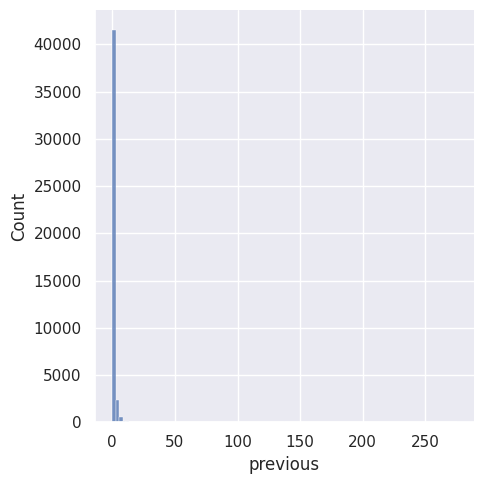

In [42]:
# sns.scatterplot(data=df, x='previous', y='y')
# sns.scatterplot(data=df, x='previous', y='age')

sns.displot(x='previous', data=df, bins=100)
# plt.ylim(0,50)
plt.show()

In [43]:
df['previous'].describe()

count    44923.000000
mean         0.581996
std          2.309077
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [44]:
print('全体の数', len(df))
print('0以外の数', len(df[df['previous']>0]))

print(len(df[df['previous']>0]) / len(df))

# 8割以上が0 → 3σ法は適さない → 適当な値を決めてclip

全体の数 44923
0以外の数 8224
0.18306880662466887


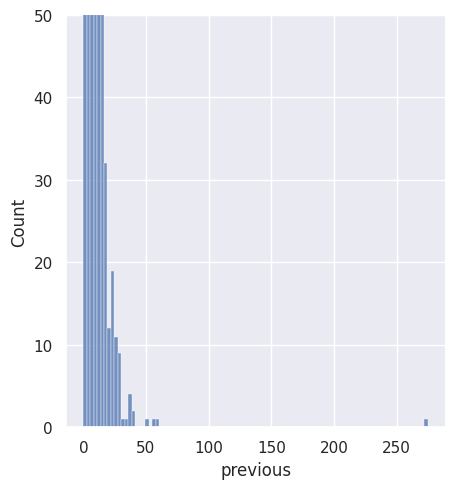

In [45]:
sns.displot(x='previous', data=df, bins=100)
plt.ylim(0,50)
plt.show()

<Axes: xlabel='previous', ylabel='y'>

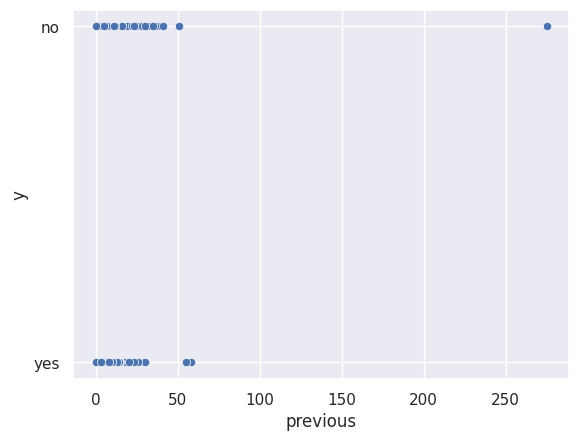

In [46]:
sns.scatterplot(data=df, x='previous', y='y')
# sns.scatterplot(data=df, x='previous', y='age')

In [47]:
# ここでは50でclipする
df.loc[df['previous']>30,'previous'] = 30

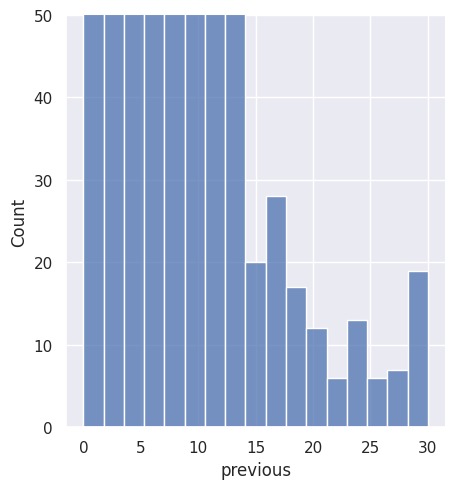

In [48]:
sns.displot(x='previous', data=df)
plt.ylim(0,50)
plt.show()

In [49]:
df['previous'].describe()

count    44923.000000
mean         0.573604
std          1.857420
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: previous, dtype: float64

## 'pdays' → ほとんどが「-1（特殊値）」なので3σ法は適さない → 適当な値365(1年)でclip + 特殊値処理

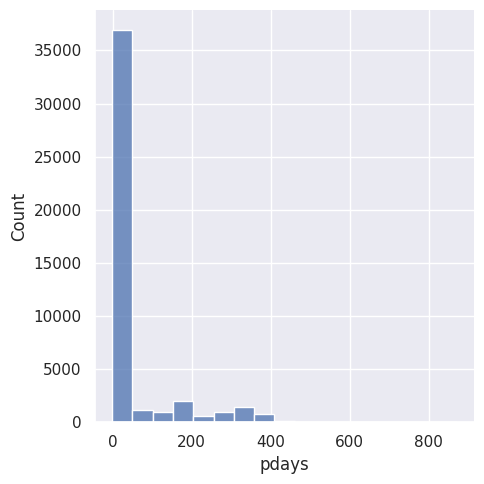

In [50]:
sns.displot(x='pdays', data=df)
# sns.displot(x='pdays', data=df, bins=100)
plt.show()

In [51]:
df['pdays'].describe()

count    44923.000000
mean        40.321016
std        100.255146
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [52]:
# ここでは365(1年)でclipする
df.loc[df['pdays']>365,'pdays'] = 365

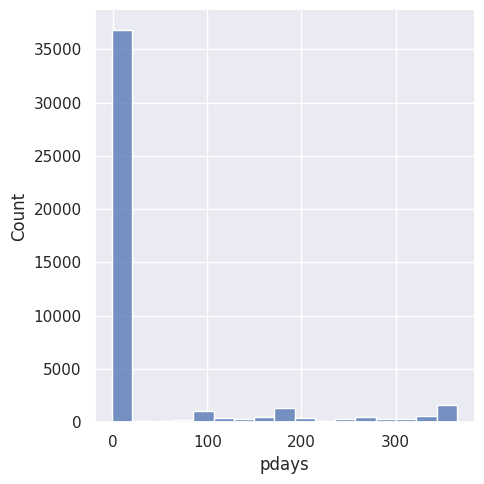

In [53]:
sns.displot(x='pdays', data=df)
plt.show()

In [54]:
df['pdays'].describe()

count    44923.000000
mean        39.378759
std         95.974112
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        365.000000
Name: pdays, dtype: float64

In [55]:
print('全体の数', len(df))
print('-1以外の数', len(df[df['pdays']!=-1]))

print(len(df[df['pdays']>0]) / len(df))

# 'previous'と同様

全体の数 44923
-1以外の数 8224
0.18306880662466887


In [56]:
# 特殊値の処理(-1 → 400)
df.loc[df['pdays']<0,'pdays'] = 400

In [57]:
df['pdays'].describe()

count    44923.000000
mean       366.968168
std         82.487581
min          1.000000
25%        400.000000
50%        400.000000
75%        400.000000
max        400.000000
Name: pdays, dtype: float64

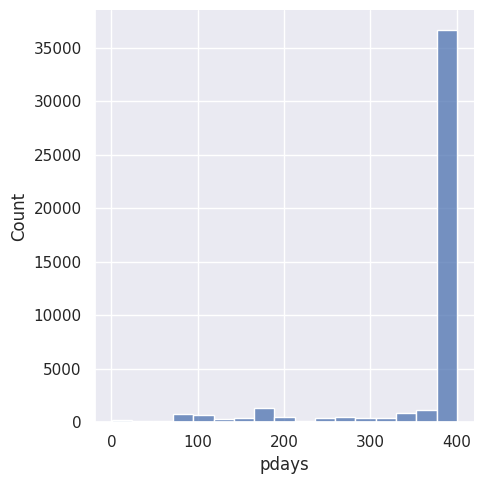

In [58]:
sns.displot(x='pdays', data=df)
# sns.displot(x='pdays', data=df, bins=100)
plt.show()

## 'duration'

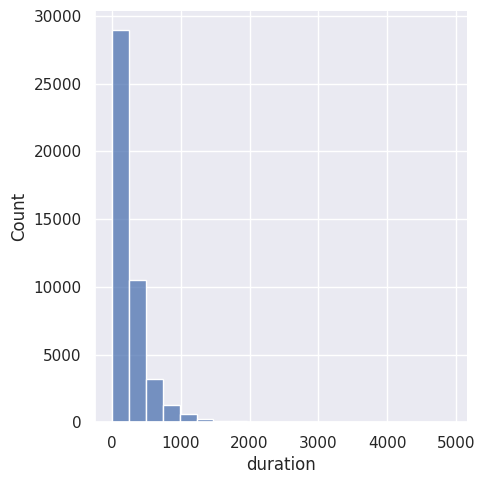

In [59]:
sns.displot(x='duration', data=df, bins=20)
plt.show()

In [60]:
df.loc[df['duration']>1500,'duration'] = 1500

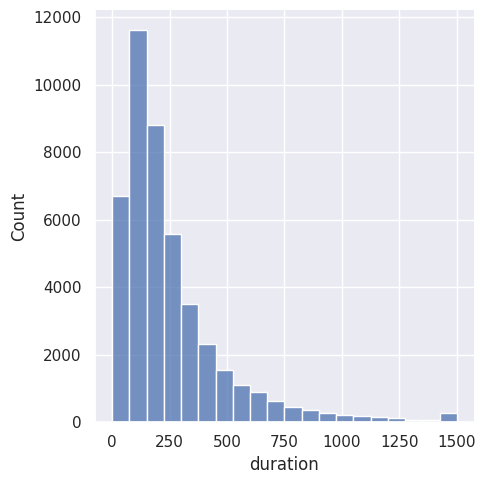

In [61]:
sns.displot(x='duration', data=df, bins=20)
plt.show()

## 'campaign'

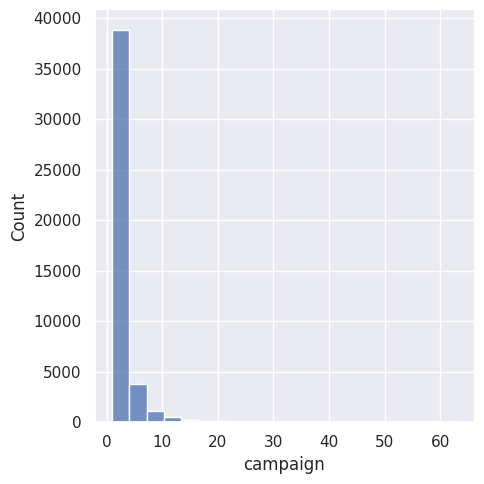

In [62]:
sns.displot(x='campaign', data=df, bins=20)
plt.show()

In [63]:
df.loc[df['campaign']>15,'campaign'] = 15

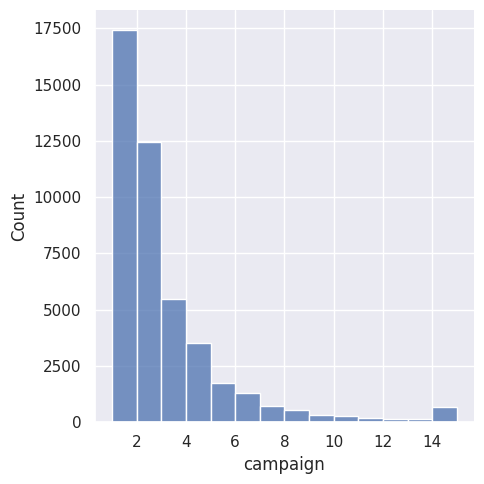

In [64]:
sns.displot(x='campaign', data=df, bins=14)
plt.show()

# 対数変換

## 'duration' → StandardScalar

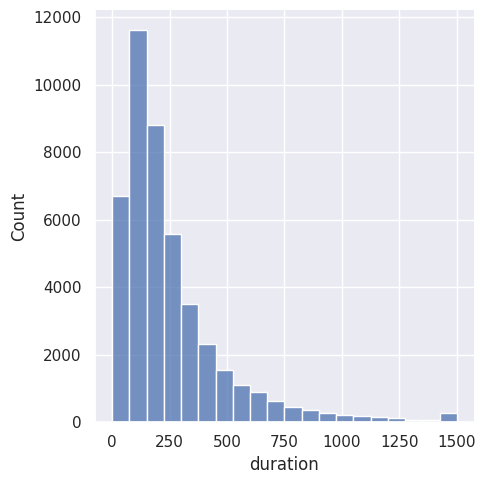

In [65]:
sns.displot(x='duration', data=df, bins=20)
plt.show()

In [66]:
# 0が値として含まれる場合にはそのまま対数をとることができないので、log(x+1)による変換がよく使われる
df['duration'] = np.log(df['duration'] + 1)

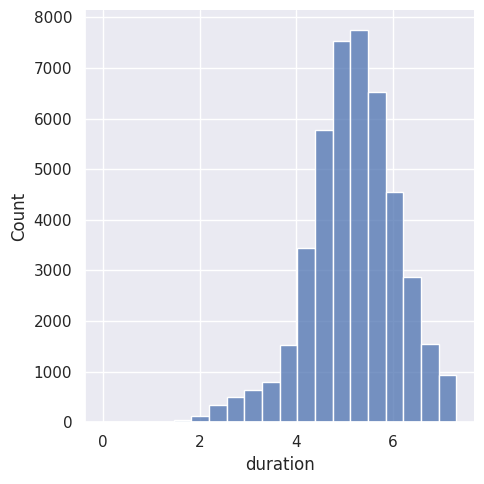

In [67]:
sns.displot(x='duration', data=df, bins=20)
plt.show()

# 特徴量エンジニアリング

## 'flag_previous'

In [68]:
# そもそも「以前のマーケティングキャンペーンにおいて顧客へ連絡したどうか」が重要になってきそう
# → 0 or 1(その他) 二値特徴量

In [69]:
print('全体の数', len(df))
print('0以外の数', len(df[df['previous']>0]))

print(len(df[df['previous']>0]) / len(df))

全体の数 44923
0以外の数 8224
0.18306880662466887


In [70]:
df['previous'].describe()

count    44923.000000
mean         0.573604
std          1.857420
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: previous, dtype: float64

In [71]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y
44918,51,technician,married,tertiary,no,825.0,no,no,cellular,6.885510,3,400,0,yes
44919,71,retired,divorced,primary,no,1729.0,no,no,cellular,6.124683,2,400,0,yes
44920,72,retired,married,secondary,no,5715.0,no,no,cellular,7.028201,5,184,3,yes
44921,57,blue-collar,married,secondary,no,668.0,no,no,telephone,6.232448,4,400,0,no
44922,37,entrepreneur,married,secondary,no,2971.0,no,no,cellular,5.891644,2,188,11,no


In [72]:
df['flag_previous'] = 0
for idx in range(len(df)):
    if df.loc[idx, 'previous'] != 0 :
        df.loc[idx, 'flag_previous'] = 1
    else:
        df.loc[idx, 'flag_previous'] = 0

In [73]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y,flag_previous
44918,51,technician,married,tertiary,no,825.0,no,no,cellular,6.885510,3,400,0,yes,0
44919,71,retired,divorced,primary,no,1729.0,no,no,cellular,6.124683,2,400,0,yes,0
44920,72,retired,married,secondary,no,5715.0,no,no,cellular,7.028201,5,184,3,yes,1
44921,57,blue-collar,married,secondary,no,668.0,no,no,telephone,6.232448,4,400,0,no,0
44922,37,entrepreneur,married,secondary,no,2971.0,no,no,cellular,5.891644,2,188,11,no,1


## 'flag_balance'

In [74]:
print(len(df[df['balance']<0]))
print(len(df[df['balance']==0]))
print(len(df[df['balance']>0]))

3762
3486
37675


In [75]:
df['flag_balance'] = 0 # 初期化

df.loc[df['balance']<0, 'flag_balance'] = -1
df.loc[df['balance']==0, 'flag_balance'] = 0
df.loc[df['balance']>0, 'flag_balance'] = 1

In [76]:
print(list(df['flag_balance'].unique()))

[1, 0, -1]


# カテゴリの数値化（カテゴリ特徴量）

## 'y' → 手動で 0 or 1

In [77]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y,flag_previous,flag_balance
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5.568345,1,400,0,no,0,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5.023881,1,400,0,no,0,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,4.343805,1,400,0,no,0,1
3,47,blue-collar,married,secondary,no,1506.0,yes,no,unknown,4.532599,1,400,0,no,0,1
4,35,management,married,tertiary,no,231.0,yes,no,unknown,4.941642,1,400,0,no,0,1


In [78]:
list(df['y'].unique())

['no', 'yes']

In [79]:
dict_mapping = {'no':0, 'yes':1}
df['y'] = df['y'].map(dict_mapping)

In [80]:
list(df['y'].unique())

[0, 1]

In [81]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y,flag_previous,flag_balance
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5.568345,1,400,0,0,0,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5.023881,1,400,0,0,0,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,4.343805,1,400,0,0,0,1
3,47,blue-collar,married,secondary,no,1506.0,yes,no,unknown,4.532599,1,400,0,0,0,1
4,35,management,married,tertiary,no,231.0,yes,no,unknown,4.941642,1,400,0,0,0,1


## 'default', 'housing', 'loan' → 手動で 0 or 1

In [82]:
print(list(df['default'].unique()))
print(list(df['housing'].unique()))
print(list(df['loan'].unique()))

['no', 'yes']
['yes', 'no']
['no', 'yes']


In [83]:
df['default'] = df['default'].map(dict_mapping)
df['housing'] = df['housing'].map(dict_mapping)
df['loan'] = df['loan'].map(dict_mapping)

In [84]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y,flag_previous,flag_balance
0,58,management,married,tertiary,0,2143.0,1,0,unknown,5.568345,1,400,0,0,0,1
1,44,technician,single,secondary,0,29.0,1,0,unknown,5.023881,1,400,0,0,0,1
2,33,entrepreneur,married,secondary,0,2.0,1,1,unknown,4.343805,1,400,0,0,0,1
3,47,blue-collar,married,secondary,0,1506.0,1,0,unknown,4.532599,1,400,0,0,0,1
4,35,management,married,tertiary,0,231.0,1,0,unknown,4.941642,1,400,0,0,0,1


## 'education' → 順序特徴量なので手動でラべリング

In [85]:
# label encoding

In [86]:
list(df['education'].unique())

['tertiary', 'secondary', 'primary']

In [87]:
dict_mapping = {
    'primary' : 0,
    'secondary' : 1,
    'tertiary' : 2,
}
df['education'] = df['education'].map(dict_mapping)

In [88]:
list(df['education'].unique())

[2, 1, 0]

## 'contact' → One Hot Encoding

In [89]:
list(df['contact'].unique())

['unknown', 'cellular', 'telephone']

In [90]:
df[['contact']]

,contact
0,unknown
1,unknown
2,unknown
3,unknown
4,unknown
...,...
44918,cellular
44919,cellular
44920,cellular
44921,telephone


In [91]:
# ダミー変数トラップを回避するためにdrop_first=Trueを指定
# ライブラリではダミー変数トラップに対処されていることが多く，drop_firstをTrueにしなくても問題なくモデルを学習させることが可能
pd.get_dummies(df[['contact']], drop_first=True)

,contact_telephone,contact_unknown
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
44918,0,0
44919,0,0
44920,0,0
44921,1,0


In [92]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,y,flag_previous,flag_balance
0,58,management,married,2,0,2143.0,1,0,unknown,5.568345,1,400,0,0,0,1
1,44,technician,single,1,0,29.0,1,0,unknown,5.023881,1,400,0,0,0,1
2,33,entrepreneur,married,1,0,2.0,1,1,unknown,4.343805,1,400,0,0,0,1
3,47,blue-collar,married,1,0,1506.0,1,0,unknown,4.532599,1,400,0,0,0,1
4,35,management,married,2,0,231.0,1,0,unknown,4.941642,1,400,0,0,0,1


In [93]:
df = pd.get_dummies(df, columns=['contact'], drop_first=True)
# one-hot encodingの対象となる列は引数columnsで指定する．
# 引数columnsを省略すると，変数の型で自動で判別するが，明示的に指定する方が無難．

In [94]:
df.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,flag_previous,flag_balance,contact_telephone,contact_unknown
0,58,management,married,2,0,2143.0,1,0,5.568345,1,400,0,0,0,1,0,1
1,44,technician,single,1,0,29.0,1,0,5.023881,1,400,0,0,0,1,0,1
2,33,entrepreneur,married,1,0,2.0,1,1,4.343805,1,400,0,0,0,1,0,1
3,47,blue-collar,married,1,0,1506.0,1,0,4.532599,1,400,0,0,0,1,0,1
4,35,management,married,2,0,231.0,1,0,4.941642,1,400,0,0,0,1,0,1


## 'marital', 'job' → One Hot Encoding

In [95]:
list(df['marital'].unique())

['married', 'single', 'divorced']

In [96]:
list(df['job'].unique())

['management',
 'technician',
 'entrepreneur',
 'blue-collar',
 'retired',
 'admin.',
 'services',
 'self-employed',
 'unemployed',
 'housemaid',
 'student']

In [97]:
df = pd.get_dummies(df, columns=['marital', 'job'], drop_first=True)

In [98]:
df.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,58,2,0,2143.0,1,0,5.568345,1,400,0,...,0,0,0,1,0,0,0,0,0,0
1,44,1,0,29.0,1,0,5.023881,1,400,0,...,0,0,0,0,0,0,0,0,1,0
2,33,1,0,2.0,1,1,4.343805,1,400,0,...,0,1,0,0,0,0,0,0,0,0
3,47,1,0,1506.0,1,0,4.532599,1,400,0,...,1,0,0,0,0,0,0,0,0,0
4,35,2,0,231.0,1,0,4.941642,1,400,0,...,0,0,0,1,0,0,0,0,0,0


# 特徴量スケーリング

In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,44923.0,40.893529,10.604399,18.000000,33.000000,39.000000,48.000000,95.000000
education,44923.0,1.143846,0.652613,0.000000,1.000000,1.000000,2.000000,2.000000
default,44923.0,0.018098,0.133306,0.000000,0.000000,0.000000,0.000000,1.000000
balance,44923.0,1236.704397,2083.709557,-7775.631548,72.000000,447.000000,1421.000000,10494.917571
housing,44923.0,0.558823,0.496533,0.000000,0.000000,1.000000,1.000000,1.000000
loan,44923.0,0.161165,0.367687,0.000000,0.000000,0.000000,0.000000,1.000000
duration,44923.0,5.171383,0.918625,0.000000,4.644391,5.198497,5.768321,7.313887
campaign,44923.0,2.676335,2.521754,1.000000,1.000000,2.000000,3.000000,15.000000
pdays,44923.0,366.968168,82.487581,1.000000,400.000000,400.000000,400.000000,400.000000
previous,44923.0,0.573604,1.857420,0.000000,0.000000,0.000000,0.000000,30.000000


## 'age' → 手動で正規化

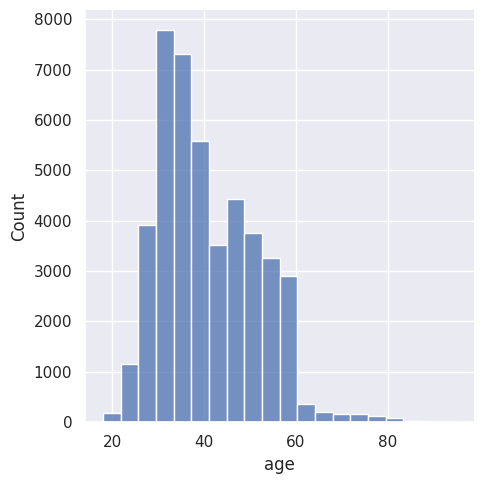

In [100]:
sns.displot(x='age', data=df, bins=20)
plt.show()

In [101]:
min = df['age'].min()
max = df['age'].max()

# 正規化
df['age'] = (df['age'] - min) / (max - min)

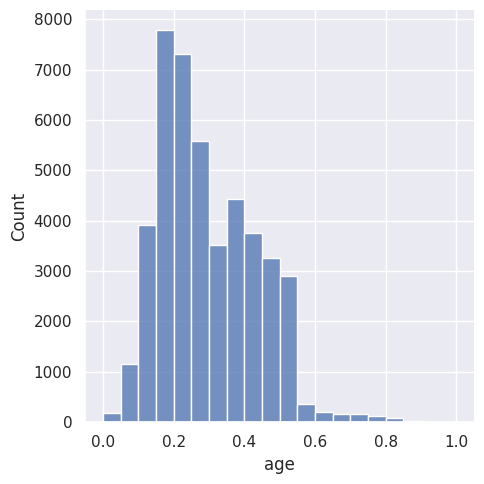

In [102]:
sns.displot(x='age', data=df, bins=20)
plt.show()

In [103]:
print(df['age'].min())
print(df['age'].max())

0.0
1.0


## 'balance' → 手動で標準化

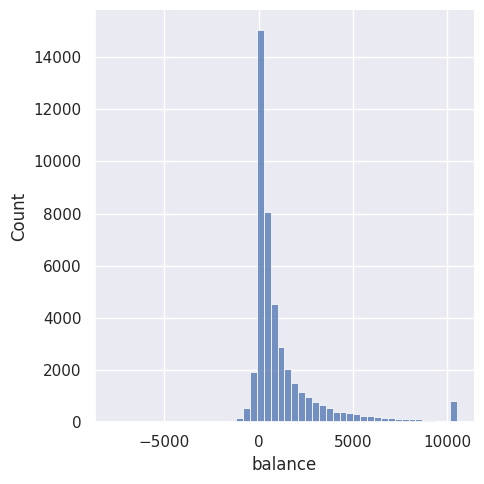

In [104]:
sns.displot(x='balance', data=df, bins=50)
plt.show()

In [105]:
mean = df['balance'].mean()
std = df['balance'].std()

# 標準化
df['balance'] = (df['balance'] - mean) / std

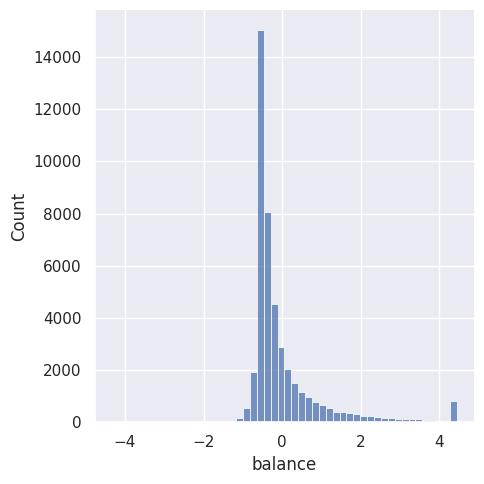

In [106]:
sns.displot(x='balance', data=df, bins=50)
plt.show()

In [107]:
print(df['balance'].mean())
print(df['balance'].std())

5.061408976320194e-18
1.0


## 'duration','campaign','pdays','previous' → 正規化

In [108]:
df[['duration','campaign','pdays','previous']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,44923.0,5.171383,0.918625,0.0,4.644391,5.198497,5.768321,7.313887
campaign,44923.0,2.676335,2.521754,1.0,1.000000,2.000000,3.000000,15.000000
pdays,44923.0,366.968168,82.487581,1.0,400.000000,400.000000,400.000000,400.000000
previous,44923.0,0.573604,1.857420,0.0,0.000000,0.000000,0.000000,30.000000


In [109]:
for col in ['duration','campaign','pdays','previous']:
    
    min = df[col].min()
    max = df[col].max()

    # 正規化
    df[col] = (df[col] - min) / (max - min)

In [110]:
df[['duration','campaign','pdays','previous']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,44923.0,0.707064,0.125600,0.0,0.63501,0.710771,0.788681,1.0
campaign,44923.0,0.119738,0.180125,0.0,0.00000,0.071429,0.142857,1.0
pdays,44923.0,0.917213,0.206736,0.0,1.00000,1.000000,1.000000,1.0
previous,44923.0,0.019120,0.061914,0.0,0.00000,0.000000,0.000000,1.0


# 可視化（前処理後）

In [111]:
df.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0.519481,2,0,0.434943,1,0,0.761339,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.337662,1,0,-0.579593,1,0,0.686896,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.194805,1,0,-0.592551,1,1,0.593912,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.376623,1,0,0.129239,1,0,0.619725,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.220779,2,0,-0.482651,1,0,0.675652,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [112]:
df.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'flag_previous', 'flag_balance',
       'contact_telephone', 'contact_unknown', 'marital_married',
       'marital_single', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed'],
      dtype='object')

## 相関行列

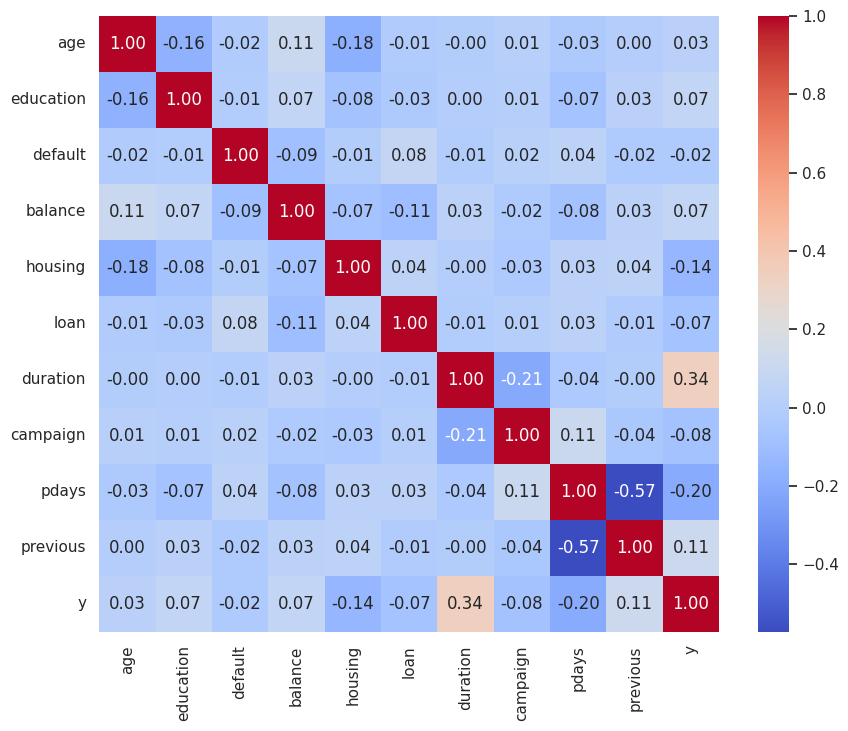

In [113]:
cols = ['age', 'education', 'default', 'balance', 'housing', 'loan', 'duration','campaign', 'pdays', 'previous', 'y']

# 相関係数を計算して、相関マトリクスを描画
corr = df[cols].corr()
# sns.heatmap(corr, cmap="coolwarm", annot=True)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt='.2f', ax=ax)
plt.show()

# データを保存（csv出力)

In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10510.0,0.301059,0.155133,0.000000,0.181818,0.272727,0.402597,1.00000
education,10510.0,1.192769,0.653460,0.000000,1.000000,1.000000,2.000000,2.00000
default,10510.0,0.013701,0.116253,0.000000,0.000000,0.000000,0.000000,1.00000
balance,10510.0,0.086966,1.060378,-2.061086,-0.534962,-0.332438,0.237099,4.44314
housing,10510.0,0.474215,0.499358,0.000000,0.000000,0.000000,1.000000,1.00000
loan,10510.0,0.130447,0.336811,0.000000,0.000000,0.000000,0.000000,1.00000
duration,10510.0,0.757538,0.128542,0.150209,0.677591,0.759235,0.851060,1.00000
campaign,10510.0,0.101053,0.158563,0.000000,0.000000,0.071429,0.142857,1.00000
pdays,10510.0,0.867572,0.258193,0.000000,0.912281,1.000000,1.000000,1.00000
previous,10510.0,0.027685,0.070609,0.000000,0.000000,0.000000,0.033333,1.00000


In [114]:
print(df.shape)
display(df.head())

(44923, 27)


,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0.519481,2,0,0.434943,1,0,0.761339,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.337662,1,0,-0.579593,1,0,0.686896,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.194805,1,0,-0.592551,1,1,0.593912,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.376623,1,0,0.129239,1,0,0.619725,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.220779,2,0,-0.482651,1,0,0.675652,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [115]:
# csvファイル出力
df.to_csv('data.csv', index=False)

In [120]:
# 読み込み
df = pd.read_csv('data.csv')

print(df.shape)
display(df.head())

(44923, 27)


,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0.519481,2,0,0.434943,1,0,0.761339,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,0.337662,1,0,-0.579593,1,0,0.686896,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.194805,1,0,-0.592551,1,1,0.593912,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.376623,1,0,0.129239,1,0,0.619725,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.220779,2,0,-0.482651,1,0,0.675652,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0


# ============================================== #

# ダウンサンプリング

In [117]:
# モデル構築時はあくまで判定モデルを作成するだけなので、学習の際にダウンサンプリングしても（すなわち運用時と条件が違っても）問題ないと思われる

# 機械学習

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


#//$// 少ない方のデータ数に合わせてダウンサンプリングを行う
print('before', df.shape)

# counts = df['y'].value_counts()
# df_majority = df[df['y']=='no']
# df_minority = df[df['y']=='yes']
df_majority = df[df['y']==0]
df_minority = df[df['y']==1]
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # オーバーサンプリングではないのでFalse
                                   n_samples=counts[1], # 少ない方のデータ数に合わせる
                                   random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# display(df_downsampled)

df = df_downsampled.copy()
df.reset_index(inplace=True, drop=True)

print('after', df.shape)
#//$//



# 訓練用とテスト用にデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# display(X_train)
# display(X_test)
# display(y_train)
# display(y_test)

# モデルを作成して学習する
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# テスト用データで予測して評価する
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

before (10510, 27)
after (10510, 27)
Accuracy: 0.8549149338374291
F1 score: 0.8651734738691259


# --- END ---